Провести анализ данных из AppMetrica по покупкам в приложении за первый квартал 2020г.

In [254]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

In [255]:
#Загружаем данные

In [256]:
df=pd.read_csv('KC_case_data .csv', parse_dates=['date'])

In [257]:
df.dtypes

date            datetime64[ns]
event                   object
purchase_sum           float64
os_name                 object
device_id                int64
gender                  object
city                    object
utm_source              object
dtype: object

In [258]:
df.head(10)

date      event  purchase_sum  os_name  device_id  gender  \
0 2020-01-01  app_start           NaN  android     669460  female   
1 2020-01-01  app_start           NaN      ios     833621    male   
2 2020-01-01  app_start           NaN  android    1579237    male   
3 2020-01-01  app_start           NaN  android    1737182  female   
4 2020-01-01  app_start           NaN      ios    4029024  female   
5 2020-01-01  app_start           NaN  android    5148476    male   
6 2020-01-01  app_start           NaN  android    8383386  female   
7 2020-01-01  app_start           NaN  android    8581267  female   
8 2020-01-01  app_start           NaN      ios   10144701  female   
9 2020-01-01  app_start           NaN      ios   10274354  female   

               city     utm_source  
0            Moscow              -  
1            Moscow         vk_ads  
2  Saint-Petersburg        referal  
3            Moscow   facebook_ads  
4            Moscow   facebook_ads  
5  Saint-Petersburg              -  
6  Saint-Petersburg         vk_ads  
7  Saint-Petersburg     google_ads  
8            Moscow              -  
9  Saint-Petersburg  instagram_ads

In [259]:
#Посмотрим на MAU по месяцам. Наибольшее количество пользователей удалось привлечь в январе.
df.resample('M', on='date').device_id.nunique()

date
2020-01-31    99161
2020-02-29    75032
2020-03-31    74623
Freq: M, Name: device_id, dtype: int64

In [260]:
#Посмотрим на Количество установок по месяцам. Наибольшее количество клиентов удалось привлечь в январе.
df.query("event=='app_install'").resample('M',on='date').device_id.nunique()

date
2020-01-31    80297
2020-02-29    38078
2020-03-31    36222
Freq: M, Name: device_id, dtype: int64

In [261]:
#Поделим пользователей на когорты в зависимости от даты установки, а затем посмотри на их CR в покупку в течение недели.
mindate = df.sort_values('date').drop_duplicates('device_id')
mindate = mindate[['device_id','date']]
mindate.rename(columns={'date':'cohort'},inplace=True)
df = df.merge(mindate, how = 'left', on = 'device_id')
df['week_number']=df.cohort.dt.week

In [262]:
df_installs=df.query('event=="app_install" or event=="purchase"').groupby(['week_number','cohort','device_id']).agg({'device_id':'count'})
df_installs.rename(columns={'device_id':'counts'},inplace=True)
df_installs.reset_index(inplace=True)
df_installs=df_installs.query('counts > 2').groupby(['week_number','cohort']).agg({'device_id':'nunique'})
df_purchases=df.query('event=="app_install"').groupby(['week_number','cohort']).agg({'device_id':'nunique'})
df_conversion=(100*df_installs.device_id / df_purchases.device_id).to_frame().reset_index()
df_conversion=df_conversion.pivot(columns='cohort',index='week_number',values='device_id')

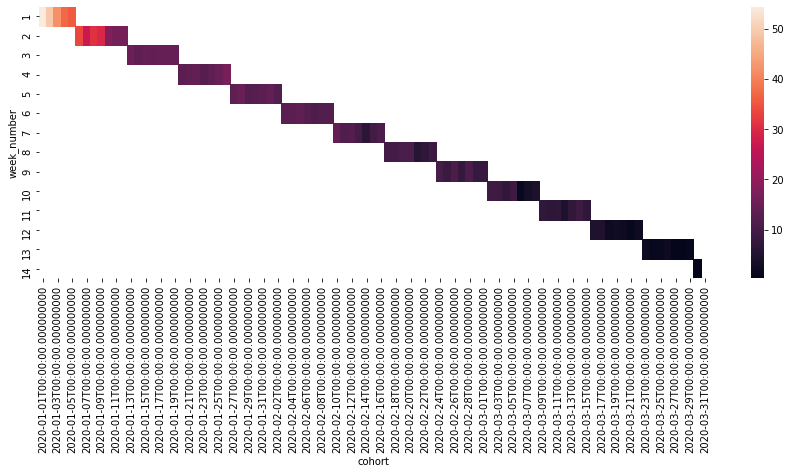

In [263]:
plt.figure(figsize=(15,5))
sns.heatmap(data=df_conversion)

In [264]:
#По результатам когортного анализа видим, что наибольший CR был в январе в первой когорте 01/01/2020.

In [265]:
#Теперь посмотрим из какого платного канала поришло больше всего пользователей. Это Яндекс.Директ.

In [266]:
df.groupby(['utm_source']).agg({'device_id':'nunique'}).sort_values('device_id',ascending=False)

device_id
utm_source              
-                  52273
yandex-direct      40712
google_ads         38096
vk_ads             34086
instagram_ads      31048
facebook_ads       25959
referal            15926

In [267]:
#Теперь посмотрим на каком этапе "отваливается" наибольшее количество пользователей:

In [268]:
df_conversion=df.groupby('event').agg({'device_id':'nunique'}).sort_values('device_id',ascending=False)

In [269]:
100-100*df_conversion.device_id/ df.device_id.nunique()

event
app_start       0.000000
search          3.350726
choose_item    18.436852
app_install    19.009975
tap_basket     34.298317
register       58.975084
purchase       62.870120
Name: device_id, dtype: float64

In [270]:
#Видно, что это этап регистрации. 

In [271]:
#Теперь посмотрим у пользователей, прешедших с какого канала, CR в покупку оказался самым высоким и самым низким.

In [272]:
utm_start=df.query('event=="app_start"').groupby('utm_source',as_index=False).agg({'device_id':'nunique'})
utm_purchase=df.query('event=="purchase"').groupby('utm_source',as_index=False).agg({'device_id':'nunique'})
utm_conversion=utm_start.merge(utm_purchase,on='utm_source')
utm_conversion['conversion']=utm_conversion.device_id_y / utm_conversion.device_id_x
utm_conversion.sort_values('conversion')

utm_source  device_id_x  device_id_y  conversion
6  yandex-direct        40707        12028    0.295477
2     google_ads        38092        11339    0.297674
0              -        52268        16598    0.317556
3  instagram_ads        31045        10762    0.346658
1   facebook_ads        25957         9017    0.347382
5         vk_ads        34079        12364    0.362804
4        referal        15924         6362    0.399523

In [273]:
#Теперь посмотрим на медианный чек по каналам привлечения.

In [274]:
check_mindate=df.query('event=="purchase"').groupby('device_id',as_index=False).agg({'date':"min"})
df_all_purchase=df.query('event=="purchase"')[['date','device_id','purchase_sum','utm_source']]
first_pay_df=check_mindate.merge(df_all_purchase, on=['device_id','date'])
first_pay_df.groupby('utm_source').agg({'purchase_sum':'median'}).sort_values('purchase_sum',ascending=False)

purchase_sum
utm_source                 
-                     398.5
referal               395.5
instagram_ads         393.5
vk_ads                393.0
yandex-direct         392.5
google_ads            390.5
facebook_ads          389.0

In [275]:
#Теперь посчитаем ROMI:

In [276]:
revenue_df=df.groupby('utm_source').agg({'purchase_sum':'sum'})
revenue_df['MI']=[0,8590498,10534878,8561626,0,9553531,10491707]
revenue_df['romi']=round(100*(revenue_df.purchase_sum-revenue_df.MI)/revenue_df.MI,2)
revenue_df.sort_values('romi',ascending=False)

purchase_sum        MI   romi
utm_source                                  
-                21449749.5         0    inf
referal           8837044.5         0    inf
vk_ads           16389652.5   9553531  71.56
instagram_ads    14546969.0   8561626  69.91
facebook_ads     12249901.0   8590498  42.60
yandex-direct    13915368.0  10491707  32.63
google_ads       12868276.0  10534878  22.15

По результатам проведенного анализа можно сделать выводы, что наибольшее количество пользователей отваливается на этапе регистрации. 
Больше пришло и своершило покупок в январе, в первую неделю. В основном пользователи приходт из Яндекс.Директ, однако конвесия в покупку по этому каналу самая низкая при ROMI в 32%.
Рекомендации:
1.Подробнее взглянуть на процесс регистрации.Провести АБ тест с упрощением формы регистрации.
2.Пересмотреть расходы и схему размещения в отношении каналов привлечения с целью достижения оптимальных показателей ROMI.
